# Imports & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Set display options for clarity
pd.set_option('display.max_colwidth', 200)


# Load Dataset

In [2]:
# Update the path if your CSV is elsewhere
df = pd.read_csv("/content/drive/MyDrive/Dataset-SA.csv")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()


Rows: 205052, Columns: 6


,product_name,product_price,Rate,Review,Summary,Sentiment
0,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,5,super!,great cooler excellent air flow and for this price its so amazing and unbelievablejust love it,positive
1,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,3,fair,the quality is good but the power of air is decent,positive
3,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,1,useless product,very bad product its a only a fan,negative
4,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,3,fair,ok ok product,neutral


# Initial Data Overview

In [3]:
# See all columns and first few rows
print("Columns:", df.columns.tolist())
df.head(10)
df.info()
df.describe(include='all')


Columns: ['product_name', 'product_price', 'Rate', 'Review', 'Summary', 'Sentiment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


,product_name,product_price,Rate,Review,Summary,Sentiment
count,205052,205052,205052,180388,205041,205052
unique,958,525,8,1324,92923,3
top,"cello Pack of 18 Opalware Cello Dazzle Lush Fiesta Opalware Dinner Set, 18 Pieces Dinner SetÃÂ ÃÂ (White, Microwave Safe)",1299,5,wonderful,good,positive
freq,6005,9150,118765,9016,17430,166581


# Missing Values & Label Distribution



Missing values per column:
product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64


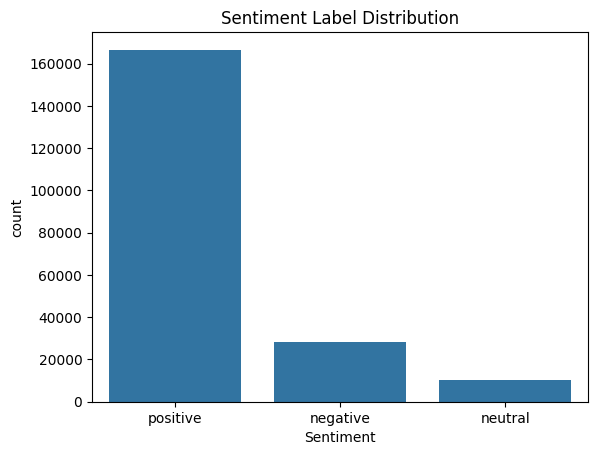

In [4]:
print("Missing values per column:")
print(df.isnull().sum())

# Sentiment label distribution
sns.countplot(data=df, x='Sentiment', order=['positive', 'negative', 'neutral'])
plt.title('Sentiment Label Distribution')
plt.show()


# EDA: Ratings, Products, and Sample Reviews

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


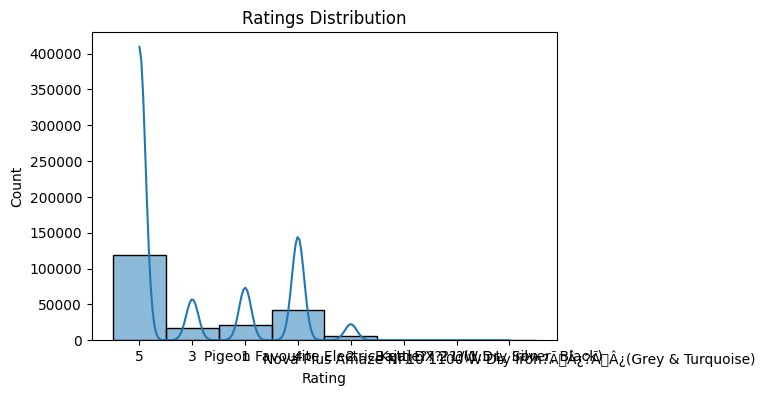


Sample positive reviews:
    Review  \
0   super!   
1  awesome   

                                                                                          Summary  
0  great cooler excellent air flow and for this price its so amazing and unbelievablejust love it  
1                                                           best budget 2 fit cooler nice cooling  

Sample negative reviews:
            Review                            Summary
3  useless product  very bad product its a only a fan
8   unsatisfactory                    very bad cooler

Sample neutral reviews:
                     Review             Summary
4                      fair       ok ok product
129  worst experience ever!  average production


In [5]:
# Ratings histogram (if exists)
if 'Rate' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['Rate'].dropna(), bins=5, kde=True)
    plt.title("Ratings Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()

# Most frequent products (if exists)
if 'Product' in df.columns:
    print(df['Product'].value_counts().head(10))

# Sample reviews by sentiment
for sent in ['positive', 'negative', 'neutral']:
    print(f"\nSample {sent} reviews:")
    print(df[df['Sentiment'] == sent][['Review', 'Summary']].head(2))


# Combine Review & Summary, Clean Text

In [6]:
# Combine Review + Summary
def join_review(row):
    return str(row.get('Review', '')) + " " + str(row.get('Summary', ''))

df['full_text'] = df.apply(join_review, axis=1)

# Hardcoded stopwords (no nltk required)
stop_words = set("""
i me my myself we our ours ourselves you your yours yourself yourselves he him his himself she her hers herself it its itself
they them their theirs themselves what which who whom this that these those am is are was were be been being have has had
having do does did doing a an the and but if or because as until while of at by for with about against between into through
during before after above below to from up down in out on off over under again further then once here there when where why
how all any both each few more most other some such no nor not only own same so than too very s t can will just don don
should now
""".split())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['full_text'].apply(clean_text)
df['clean_text'].head()


,clean_text
0,super great cooler excellent air flow price amazing unbelievablejust love
1,awesome best budget fit cooler nice cooling
2,fair quality good power air decent
3,useless product bad product fan
4,fair ok ok product


# More EDA: Word Clouds and N-grams

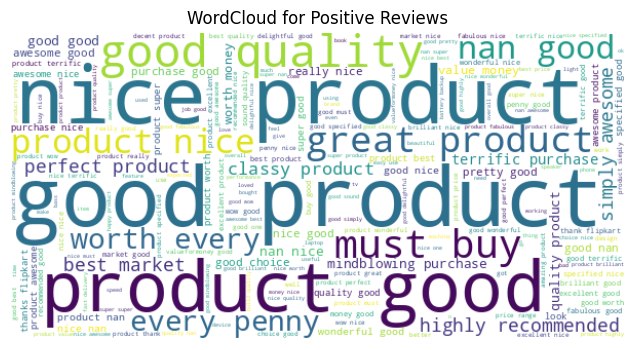

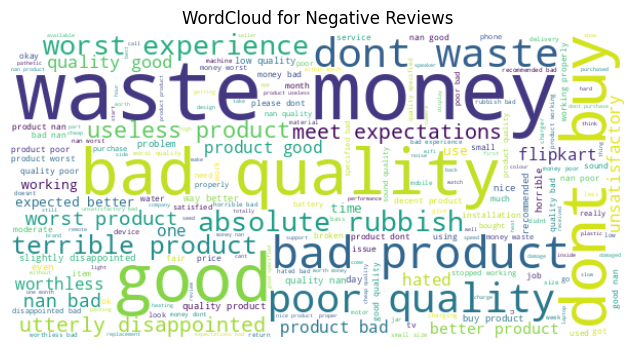

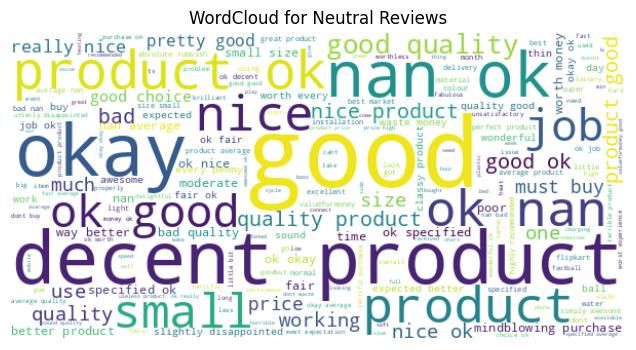

In [7]:
from wordcloud import WordCloud

def plot_wordcloud(text, title="WordCloud"):
    wc = WordCloud(width=600, height=300, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word clouds per sentiment
for sent in ['positive', 'negative', 'neutral']:
    plot_wordcloud(df[df['Sentiment'] == sent]['clean_text'], title=f"WordCloud for {sent.capitalize()} Reviews")


# Prepare Modeling Data

In [8]:
# Filter only valid labels
df = df[df['Sentiment'].isin(['positive', 'negative', 'neutral'])]
X = df['clean_text']
y = df['Sentiment'].str.capitalize()  # 'Positive', 'Negative', 'Neutral'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (174294,) Test size: (30758,)


# Feature Engineering (TF-IDF)

In [9]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF vector shape: {X_train_vec.shape}")


TF-IDF vector shape: (174294, 5000)


# Train Logistic Regression Model

In [10]:
model = LogisticRegression(multi_class="multinomial", class_weight="balanced", max_iter=200, random_state=42)
model.fit(X_train_vec, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=200,
                   multi_class='multinomial', random_state=42)

# Model Evaluation

Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.84      0.81      4235
     Neutral       0.31      0.71      0.43      1536
    Positive       0.98      0.89      0.94     24987

    accuracy                           0.88     30758
   macro avg       0.69      0.81      0.73     30758
weighted avg       0.92      0.88      0.89     30758

Confusion Matrix:
 [[ 3556   474   205]
 [  250  1087   199]
 [  711  1955 22321]]


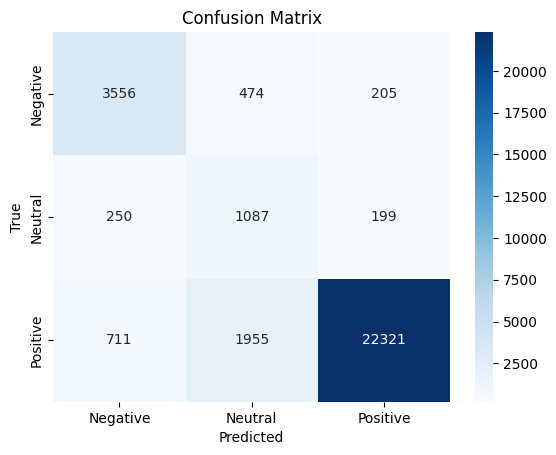

In [11]:
y_pred = model.predict(X_test_vec)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Save Model and Vectorizer

In [12]:
os.makedirs("model", exist_ok=True)
joblib.dump(model, "model/model.pkl")
joblib.dump(vectorizer, "model/vectorizer.pkl")
print("✅ Model and vectorizer saved in /model folder.")


✅ Model and vectorizer saved in /model folder.


# Predict on New Examples

In [13]:
def predict_sentiment(text):
    ct = clean_text(text)
    feats = vectorizer.transform([ct])
    return model.predict(feats)[0]

# Test
for example in ["Excellent cooler, loved it!", "Bad quality, broke in 2 days", "Just okay, nothing special"]:
    print(f"{example} ➡️ {predict_sentiment(example)}")


Excellent cooler, loved it! ➡️ Positive
Bad quality, broke in 2 days ➡️ Negative
Just okay, nothing special ➡️ Negative
